In [1]:

import math

"""
Conditional Graph Neural Network Implementation for Graph Link Prediction

This module implements a conditional graph neural network architecture based on the message passing
paradigm, specifically designed for graph link prediction tasks. The implementation uses PyTorch
Geometric and PyTorch Lightning frameworks.

The key components of this implementation are:

1. FilmConditionalLinear: A conditional linear layer using Feature-wise Linear Modulation (FiLM)
   that allows neural network behavior to be conditioned on external inputs.

2. ConditionalGraphAttention: A graph attention layer that extends PyTorch Geometric's MessagePassing
   class, incorporating attention mechanisms and conditional processing via FiLM.

3. ConditionalGIN: A Graph Isomorphism Network that uses the conditional graph attention mechanism
   for message passing and is trained to predict whether edges should exist in the graph.

The module demonstrates how to:
- Create conditional neural network layers with FiLM
- Implement custom message passing mechanisms with attention
- Apply graph neural networks to link prediction tasks
- Generate and visualize mock graph data for testing
"""
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing


class FilmConditionalLinear(nn.Module):
    """
    This is a conditional variant of the default ``Linear`` layer using the FiLM conditioning mechanism.

    As a conditional layer, this layer requires 2 different input tensors. The first is the actual input
    tensor to be transformed into the output tensor and the second is the condition vector that should
    modify the behavior of the linear layer. The implementation follows the Feature-wise Linear Modulation
    (FiLM) approach, which applies an affine transformation (scale and shift) to the output of a linear
    layer based on the conditioning vector.

    :param in_features: Number of input features
    :param out_features: Number of output features
    :param condition_features: Number of features in the conditioning vector
    :param film_units: List of hidden unit sizes for the FiLM network
    :param film_use_norm: Whether to use batch normalization in the FiLM network
    """

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 condition_features: int,
                 film_units: list[int] = [128, ],
                 film_use_norm: bool = False,
                 **kwargs,
                 ):
        """
        Initialize the FiLM conditional linear layer.

        :param in_features: Number of input features
        :param out_features: Number of output features
        :param condition_features: Number of features in the conditioning vector
        :param film_units: List of hidden unit sizes for the FiLM network
        :param film_use_norm: Whether to use batch normalization in the FiLM network
        :param kwargs: Additional keyword arguments to pass to the parent class
        """
        nn.Module.__init__(self, **kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.condition_features = condition_features
        self.film_units = film_units
        self.film_use_norm = film_use_norm
        # The final activation we actually want to be Tanh because the output values should
        # be in the range of [-1, 1], both for the bias as well as the multiplicative factor.
        # TODO: Make this configurable.
        self.lay_final_activation = nn.Tanh()

        ## -- Main Linear Layer --
        # Ultimately, the FiLM layer is just a variation of a linear layer where the output
        # is additionally modified by the activation. So what we define here is the core
        # linear layer itself.
        self.lay_linear = nn.Linear(
            in_features=in_features,
            out_features=out_features,
        )
        self.dim = out_features

        ## -- FiLM Layers --
        # These are the layers that will be used to create the FiLM activation modifier tensors.
        # They take as the input the condition vector and transform that into the additive and
        # multiplicative modifiers which than perform the affine transformation on the output
        # of the actual linear layer.
        # This can even be a multi-layer perceptron by itself, depending on how difficult the
        # condition function is to learn.
        self.film_layers = nn.ModuleList()
        prev_features = condition_features
        for num_features in film_units:
            if self.film_use_norm:
                lay = nn.Sequential(
                    nn.Linear(
                        in_features=prev_features,
                        out_features=num_features
                    ),
                    # CHANGED: BatchNorm1d -> LayerNorm
                    # nn.BatchNorm1d(num_features),
                    nn.LayerNorm(num_features),
                    nn.ReLU(),
                )
            else:
                lay = nn.Sequential(
                    nn.Linear(
                        in_features=prev_features,
                        out_features=num_features
                    ),
                    nn.ReLU(),
                )

            self.film_layers.append(lay)
            prev_features = num_features

        # Finally, at the end of this MLP we need the final layer to be one that outputs a
        # vector of the size that is twice the size of the output of the core linear layer.
        # From this output we need to derive the additive and the multiplicative modifier
        # and we do this by using the first half of the output as the multiplicative
        # modifier and the second half as the additive modifier.
        self.film_layers.append(nn.Linear(
            in_features=prev_features,
            out_features=self.dim * 2,
        ))

    def forward(self,
                input: torch.Tensor,
                condition: torch.Tensor
                ) -> torch.Tensor:
        """
        Forward pass of the FiLM conditional linear layer.

        The forward method applies the core linear transformation to the input tensor,
        then modifies the result based on the condition tensor through a FiLM (Feature-wise
        Linear Modulation) mechanism, which performs an affine transformation with parameters
        derived from the condition.

        :param input: Input tensor of shape (batch_size, in_features)
        :param condition: Condition tensor of shape (batch_size, condition_features)

        :returns: Output tensor of shape (batch_size, out_features)
        """

        ## -- getting the modifier from the condition --
        # We need the film layers to create the activation modifier tensor.
        # This actually may or may not be a multi layer perceptron.
        modifier = condition
        for lay in self.film_layers:
            modifier = lay(modifier)

        # Reduced the factor 2 -> 0.5
        # The predictions jump from 0 to 1 and 1 to 0 within one single training loop, that indicates numerical instability
        # and possibly high activation values
        modifier = 0.5 * self.lay_final_activation(modifier)

        # -- getting the output from the linear layer --
        output = self.lay_linear(input)

        # -- applying the modifier to the output --
        # And then finally we split the modifier vector into the two equally sized distinct vectors where one of them
        # is the multiplicative modification and the other is the additive modification to the output activation.
        factor = modifier[:, :self.dim]
        bias = modifier[:, self.dim:]
        output = (factor * output) + bias

        return output


class ConditionalGraphAttention(MessagePassing):
    """
    A conditional graph attention layer that extends PyTorch Geometric's MessagePassing base class.

    This layer implements a message passing mechanism where attention coefficients are computed
    for each edge based on the features of the connected nodes and edge attributes, modified by
    a condition vector. The attention mechanism helps the network focus on the most relevant
    parts of the graph structure for the given task and condition.

    :param in_dim: Dimension of input node features
    :param out_dim: Dimension of output node features
    :param edge_dim: Dimension of edge features
    :param cond_dim: Dimension of the condition vector
    :param hidden_dim: Dimension of hidden layers
    :param eps: Epsilon value for residual connections
    :param film_units: List of hidden unit sizes for the FiLM networks
    """

    def __init__(self,
                 in_dim: int,
                 out_dim: int,
                 cond_dim: int,
                 edge_dim: int = 0,
                 hidden_dim: int = 64,
                 eps: float = 0.1,
                 film_units: list[int] = [],
                 **kwargs):
        """
        Initialize the conditional graph attention layer.

        :param in_dim: Dimension of input node features
        :param out_dim: Dimension of output node features
        :param edge_dim: Dimension of edge features
        :param cond_dim: Dimension of the condition vector
        :param hidden_dim: Dimension of hidden layers
        :param eps: Epsilon value for residual connections
        :param film_units: List of hidden unit sizes for the FiLM networks
        :param kwargs: Additional keyword arguments to pass to the parent class
        """
        kwargs.setdefault('aggr', 'add')
        MessagePassing.__init__(self, **kwargs)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.edge_dim = edge_dim
        self.cond_dim = cond_dim
        self.hidden_dim = hidden_dim
        self.eps = eps
        self.film_units = film_units

        self._attention_logits = None
        self._attention = None

        ## -- Initial Embedding Layer --
        self.message_dim = (in_dim * 2 + edge_dim)
        self.lay_message_lin_1 = FilmConditionalLinear(
            in_features=self.message_dim,
            out_features=self.hidden_dim,
            condition_features=self.cond_dim,
            film_units=self.film_units,
        )
        # CHANGE: replaced BatchNorm1d with LayerNorm
        self.lay_message_bn = nn.LayerNorm(self.hidden_dim)
        self.lay_message_act = nn.LeakyReLU()
        self.lay_message_lin_2 = FilmConditionalLinear(
            in_features=self.hidden_dim,
            out_features=self.hidden_dim,
            condition_features=self.cond_dim,
            film_units=self.film_units,
        )

        # -- Attention Layer --
        # This layer will produce the attention coefficients which will then be used in the
        # attention-weighted message accumulation step.
        self.lay_attention_lin_1 = FilmConditionalLinear(
            in_features=self.message_dim,
            out_features=self.hidden_dim,
            condition_features=self.cond_dim,
            film_units=self.film_units,
        )
        # CHANGE: replaced BatchNorm1d with LayerNorm
        self.lay_attention_bn = nn.LayerNorm(self.hidden_dim)
        self.lay_attention_act = nn.LeakyReLU()
        self.lay_attention_lin_2 = FilmConditionalLinear(
            in_features=self.hidden_dim,
            out_features=1,  # attention logits
            condition_features=self.cond_dim,
            film_units=self.film_units,
        )

        # -- Final Transform Layer --
        # In the end we add an additional transformation on the attention weighted aggregation
        # of the message to determine the update to the node features.
        self.lay_transform_lin_1 = FilmConditionalLinear(
            in_features=self.hidden_dim + self.in_dim,
            out_features=self.hidden_dim,
            condition_features=self.cond_dim,
            film_units=self.film_units,
        )
        self.lay_transform_bn = nn.BatchNorm1d(self.hidden_dim)
        self.lay_transform_act = nn.LeakyReLU()
        self.lay_transform_lin_2 = FilmConditionalLinear(
            in_features=self.hidden_dim,
            out_features=self.out_dim,
            condition_features=self.cond_dim,
            film_units=self.film_units,
        )

    def message(self,
                x_i, x_j,
                condition_i, condition_j,
                # edge_attr,
                edge_weights,
                ) -> torch.Tensor:
        """
        Compute the message for each edge in the message passing step.

        This method is called for each edge during the propagation step of message passing.
        It computes attention coefficients based on the features of connected nodes and the edge,
        then uses these coefficients to weight the message being passed.

        :param x_i: Features of the target node
        :param x_j: Features of the source node
        :param condition_i: Condition vector for the target node
        :param condition_j: Condition vector for the source node
        :param edge_attr: Edge attributes
        :param edge_weights: Optional edge weights to further modulate the messages

        :returns: The weighted message to be passed along the edge
        """

        # message = torch.cat([x_i, x_j, edge_attr], dim=-1)
        message = torch.cat([x_i, x_j], dim=-1)

        attention_logits = self.lay_attention_lin_1(message, condition_i)
        attention_logits = self.lay_attention_bn(attention_logits)
        attention_logits = self.lay_attention_act(attention_logits)
        attention_logits = self.lay_attention_lin_2(attention_logits, condition_i)
        self._attention_logits = attention_logits
        self._attention = F.sigmoid(self._attention_logits)

        message_transformed = self.lay_message_lin_1(message, condition_i)
        message_transformed = self.lay_message_bn(message_transformed)
        message_transformed = self.lay_message_act(message_transformed)
        message_transformed = self.lay_message_lin_2(message_transformed, condition_i)

        result = self._attention * message_transformed

        if edge_weights is not None:
            if edge_weights.dim() == 1:
                edge_weights = torch.unsqueeze(edge_weights, dim=-1)

            result *= edge_weights

        return result

    def forward(self,
                x: torch.Tensor,
                condition: torch.Tensor,
                # edge_attr: torch.Tensor,
                edge_index: torch.Tensor,
                edge_weights: torch.Tensor = None,
                **kwargs) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the conditional graph attention layer.

        This method implements the full message passing operation, including propagation of messages
        along edges and aggregation of these messages at each node. The final node embeddings are
        computed by transforming the aggregated messages together with the original node features.

        :param x: Input node features
        :param condition: Condition vector for all nodes
        :param edge_attr: Edge attributes
        :param edge_index: Graph connectivity
        :param edge_weights: Optional edge weights
        :param kwargs: Additional keyword arguments

        :returns: A tuple containing the updated node embeddings and attention logits
        """

        self._attention = None
        self._attention_logits = None

        # node_embedding: (B * V, out)
        node_embedding = self.propagate(
            edge_index,
            x=x,
            condition=condition,
            # edge_attr=edge_attr,
            edge_weights=edge_weights,
        )

        # node_embedding = self.lay_act(node_embedding)
        x = self.lay_transform_lin_1(
            torch.cat([node_embedding, x], axis=1),
            condition
        )
        x = self.lay_transform_bn(x)
        x = self.lay_transform_act(x)
        x = self.lay_transform_lin_2(x, condition)

        # Residual connection to make the gradient flow more stable.
        #node_embedding += self.eps * x
        node_embedding = x

        return node_embedding, self._attention_logits


class ConditionalGIN(pl.LightningModule):
    """
    A conditional Graph Isomorphism Network (GIN) implemented using PyTorch Lightning.

    This model performs message passing on graph structured data conditioned on an external
    vector. It uses the conditional graph attention mechanism to propagate information through
    the graph. The model is designed for link prediction tasks, predicting whether edges should
    exist in the graph based on the learned node representations and the condition vector.

    :param input_dim: Dimension of input node features
    :param edge_dim: Dimension of edge features
    :param condition_dim: Dimension of the condition vector
    :param cond_units: List of hidden unit sizes for the condition embedding network
    :param conv_units: List of hidden unit sizes for the graph convolution layers
    :param film_units: List of hidden unit sizes for the FiLM networks in the graph attention layers
    :param link_units: List of hidden unit sizes for the link prediction network
    :param learning_rate: Learning rate for the optimizer
    """

    def __init__(self,
                 input_dim: int,
                 condition_dim: int,
                 edge_dim: int = 0,
                 cond_units: list[int] = [256, 128],
                 conv_units: list[int] = [64, 64, 64],
                 film_units: list[int] = [128, ],
                 link_units: list[int] = [256, 64, 1],
                 learning_rate: float = 0.0001,
                 ):
        """
        Initialize the conditional GIN model.

        :param input_dim: Dimension of input node features
        :param edge_dim: Dimension of edge features
        :param condition_dim: Dimension of the condition vector
        :param cond_units: List of hidden unit sizes for the condition embedding network
        :param conv_units: List of hidden unit sizes for the graph convolution layers
        :param film_units: List of hidden unit sizes for the FiLM networks in the graph attention layers
        :param link_units: List of hidden unit sizes for the link prediction network
        :param learning_rate: Learning rate for the optimizer
        """

        super().__init__()

        # ─── CHANGE: add per-node categorical embeddings ───────────────────────
        self.atom_emb   = nn.Embedding(num_embeddings=28, embedding_dim=64)    # CHANGE
        self.degree_emb = nn.Embedding(num_embeddings=6,  embedding_dim=16)     # CHANGE
        self.node_id_emb = nn.Embedding(num_embeddings=8*18,  embedding_dim=32)     # CHANGE
        self.input_proj = nn.Linear(64 + 16 + 32, input_dim)                  # CHANGE
        # ──────────────────────────────────────────────────────────────────────

        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.conv_units = conv_units
        self.learning_rate = learning_rate

        ## == LAYER DEFINITIONS ==

        ## -- Condition Layers --

        # These will be the layers (the mlp) which will be used to create an overall lower-dimensional
        # embedding representation of the (very high-dimensional) condition vector. It is then this
        # embedding that will be used in the individual FiLM conditioning layers.
        self.cond_layers = nn.ModuleList()
        prev_units = condition_dim
        for units in cond_units:
            self.cond_layers.append(
                nn.Linear(prev_units, units),
            )
            prev_units = units

        self.cond_embedding_dim = prev_units

        ## -- Graph Convolutional Layers --

        # These will be the actual convolutional layers that will be used as the message passing
        # operations on the given graph.
        self.conv_layers = nn.ModuleList()
        prev_units = input_dim
        for units in conv_units:
            lay = ConditionalGraphAttention(
                in_dim=prev_units,
                out_dim=units,
                edge_dim=0,
                cond_dim=self.cond_embedding_dim,
                film_units=film_units,
            )
            self.conv_layers.append(lay)
            prev_units = units

        # -- Edge Prediction Layers --

        # Finally, after the message passing and so on, we need to have some kind of network which
        # takes the messages (edge dimension) as an input and produces the binary classification
        # of whether that edge should exist or not.

        self.link_layers = nn.ModuleList()
        prev_units = self.conv_units[-1] * 2
        for i, units in enumerate(link_units):
            if i == len(link_units) - 1:
                # The last layer should not have the batch norm and activation.
                self.link_layers.append(
                    nn.Linear(prev_units, units),
                )
            else:
                self.link_layers.append(nn.Sequential(
                    nn.Linear(prev_units, units),
                    # CHANGED: BatchNorm -> LayerNorm
                    nn.LayerNorm(units),
                    nn.ReLU(),
                ))
            prev_units = units

        # For the binary classification task we obviously want a sigmoid activation at the end
        self.lay_link_act = nn.Sigmoid()

        # ─── CHANGE: initialize final bias to match dataset’s positive rate ───
        #    assume you know `p = (#positives)/(#edges)` up front
        p = 288 / 1344  # <– replace with your actual base‐rate
        final_lin = self.link_layers[-1]
        nn.init.zeros_(final_lin.weight)               # CHANGE: zero‐init final weights
        final_lin.bias.data.fill_(-math.log((1-p)/p))  # CHANGE: set bias = logit(p)

    def forward(self, data: Data):
        """
        Forward pass of the conditional GIN model.

        This method processes the input graph data through the condition embedding network,
        the graph convolutional layers, and finally the link prediction network to predict
        edge existence probabilities.

        :param data: PyTorch Geometric Data object containing the graph

        :returns: Dictionary containing the edge prediction probabilities
        """

        ## -- embedding the condition --
        cond: torch.Tensor = data.cond
        for lay in self.cond_layers:
            cond = lay(cond)

        if not hasattr(data, 'edge_weights'):
            data.edge_weights = None

        # ─── CHANGE: build node features from categorical IDs ───────────────
        atom_ids   = data.x[:, 0].long()      # assume in [0..27]
        degree_ids = data.x[:, 1].long()      # assume in [0..5]
        # use the row-index in data.x as the unique node ID
        node_ids = torch.arange(data.x.size(0), device=data.x.device)
        e_id     = self.node_id_emb(node_ids)
        e_atom     = self.atom_emb(atom_ids)
        e_degree   = self.degree_emb(degree_ids)
        node_embedding = self.input_proj(torch.cat([e_atom, e_degree, e_id], dim=-1))
        # ──────────────────────────────────────────────────────────────────────


        ## -- message passing --
        # CHANGE: Use the learned embedding
        # node_embedding = data.x
        for lay_conv in self.conv_layers:
            node_embedding, _ = lay_conv(
                x=node_embedding,
                condition=cond,
                edge_attr=data.edge_attr,
                edge_index=data.edge_index,
                # edge_weights=data.edge_weights,
            )

        ## -- link prediction --
        node_embedding_i = node_embedding[data.edge_index[0]]
        node_embedding_j = node_embedding[data.edge_index[1]]
        edge_embedding = torch.cat(
            [node_embedding_i + node_embedding_j, torch.abs(node_embedding_i - node_embedding_j)], dim=-1)

        for lay_link in self.link_layers:
            edge_embedding = lay_link(edge_embedding)

        # Sigmoid activation to get the final edge prediction probabilities.
        edge_prediction = self.lay_link_act(edge_embedding)

        return {
            'edge_prediction': edge_prediction,
        }

    def training_step(self, batch: Data, batch_idx):
        """
        Perform a single training step.

        This method is called by PyTorch Lightning during training. It computes the forward pass
        and calculates the binary cross-entropy loss between the predicted edge probabilities
        and the target edge labels.

        :param batch: PyTorch Geometric Data object containing a batch of graphs
        :param batch_idx: Index of the current batch

        :returns: Loss value for the current training step
        """

        batch.edge_y = batch.edge_y.float()

        result: dict = self(batch)
        edge_prediction = result['edge_prediction']

        edge_target = batch.edge_y.view(-1, 1)
        loss = F.binary_cross_entropy(
            edge_prediction,
            edge_target,
            reduction='mean',
        )

        self.log('loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        """
        Configure optimizers for the model.

        This method is called by PyTorch Lightning to set up the optimizer
        for training the model.

        :returns: The configured optimizer
        """
        # CHANGE: added weight decay
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)


In [2]:
from src.datasets import AddNodeDegree
from torch_geometric.datasets import ZINC

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

batch_size = 2
dataset = ZINC(root="/Users/arvandkaveh/Projects/kit/graph_hdc/datasets/test/zinc_subset_with_degree",
               pre_transform=AddNodeDegree())[:2]

# Take the first graph for visualization and model testing
sample_data = dataset[1]

print(f"Sample graph info:")
print(f"Number of nodes: {sample_data.x.size(0)}")
print(f"Number of edges: {sample_data.edge_index.size(1)}")
print(f"Node feature dimension: {sample_data.x.size(1)}")
# print(f"Edge feature dimension: {sample_data.edge_attr.size(1)}")
# print(f"Condition dimension: {sample_data.cond.size(1)}")


Sample graph info:
Number of nodes: 18
Number of edges: 36
Node feature dimension: 2


In [3]:


## Reconstruct
# Original
existing_edges = list(zip(sample_data.edge_index[0].tolist(), sample_data.edge_index[1].tolist()))
x = sample_data.x
x_list = list(map(tuple, x.tolist()))
existing_edges_tuples = {(x_list[u], x_list[v]) for u, v in existing_edges}

assert len(existing_edges_tuples) < len(existing_edges)
# Sorted

## First sort by the **secondary key** (column 1)
idx1 = torch.argsort(x[:, 1], stable=True)

## Then sort the result by the **primary key** (column 0)
x1 = x[idx1]
idx2 = torch.argsort(x1[:, 0], stable=True)

## Final sort index
sort_idx = idx1[idx2]

sort_idx_l = sort_idx.tolist()
for idx in sort_idx_l:
    print(x[idx])

y = []
initial_edge_guess = []
num_nodes = sample_data.x.size(0)
uniques = set()
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if (x_list[i], x_list[j]) in existing_edges_tuples:
            if (i, j) in existing_edges:
                print("---Edge exists")
                print(i, j)
                print(x_list[i], x_list[j])
                # Edge exists
                if (i, j) not in initial_edge_guess:
                    initial_edge_guess.append((i, j))
                    y.append(1)
                    uniques.add(i)
                    uniques.add(j)

                    initial_edge_guess.append((j, i))
                    y.append(1)
            else:
                # Edge does not exist
                if (i, j) not in initial_edge_guess:
                    initial_edge_guess.append((i, j))
                    y.append(0)
                    initial_edge_guess.append((j, i))
                    y.append(0)

print(uniques)
print(initial_edge_guess)

sample_data.edge_y = torch.tensor(y).float()
sample_data.sort_idx = sort_idx_l

edge_index_init_tensor = torch.tensor(list(zip(*initial_edge_guess)), dtype=torch.long)
sample_data.edge_index_old = sample_data.edge_index
sample_data.edge_index = edge_index_init_tensor

print(f"Sample graph info:")
print(f"Number of nodes: {sample_data.x.size(0)}")
print(f"Number of edges: {sample_data.edge_index.size(1)}")
print(f"Node feature dimension: {sample_data.x.size(1)}")
# print(f"Edge feature dimension: {sample_data.edge_attr.size(1)}")
# print(f"Condition dimension: {sample_data.cond.size(1)}")
print(f"edge_y: {sample_data.edge_y}")


tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 2.])
tensor([0., 2.])
tensor([0., 2.])
tensor([0., 2.])
tensor([0., 2.])
tensor([0., 2.])
tensor([0., 2.])
tensor([0., 3.])
tensor([0., 3.])
tensor([0., 3.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 2.])
tensor([2., 3.])
tensor([4., 3.])
---Edge exists
0 1
(0.0, 1.0) (1.0, 2.0)
---Edge exists
1 2
(1.0, 2.0) (0.0, 2.0)
---Edge exists
2 3
(0.0, 2.0) (0.0, 2.0)
---Edge exists
3 4
(0.0, 2.0) (4.0, 3.0)
---Edge exists
4 5
(4.0, 3.0) (0.0, 1.0)
---Edge exists
4 6
(4.0, 3.0) (0.0, 3.0)
---Edge exists
6 7
(0.0, 3.0) (1.0, 1.0)
---Edge exists
6 8
(0.0, 3.0) (2.0, 3.0)
---Edge exists
8 9
(2.0, 3.0) (0.0, 1.0)
---Edge exists
8 10
(2.0, 3.0) (0.0, 2.0)
---Edge exists
10 11
(0.0, 2.0) (0.0, 3.0)
---Edge exists
11 12
(0.0, 3.0) (0.0, 2.0)
---Edge exists
11 17
(0.0, 3.0) (0.0, 2.0)
---Edge exists
12 13
(0.0, 2.0) (0.0, 2.0)
---Edge exists
13 14
(0.0, 2.0) (0.0, 3.0)
---Edge exists
14 15
(0.0, 3.0) (1.0, 1.0)
---Edge exists
14 16
(0.0

In [4]:
from torch_geometric.data import Batch

# Create a batch of the same graph to overfit
batch_size = 1
batch_list = []
for _ in range(batch_size):
    batch_list.append(sample_data)
batch = Batch.from_data_list(batch_list)
print(batch.edge_index.shape)
print(batch.edge_y.shape)


# res = hypernet.forward(data=batch)
# x = torch.stack([res["node_terms"], res["edge_terms"], res["graph_embedding"]], dim=1)

torch.Size([2, 168])
torch.Size([168])


In [5]:
from src.encoding.the_types import VSAModel
from src.encoding.configs_and_constants import SupportedDataset
import torch
from torch_geometric.data import DataLoader

vsa = "HRR"
hv_dim = 80 * 80
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42

ds = SupportedDataset.ZINC_NODE_DEGREE_COMB
ds.default_cfg.vsa = VSAModel(vsa)
ds.default_cfg.hv_dim = hv_dim
ds.default_cfg.device = device
ds.default_cfg.seed = seed
# Disable edge and graph features
ds.default_cfg.edge_feature_configs = {}
ds.default_cfg.graph_feature_configs = {}

from src.encoding.graph_encoders import HyperNet

hypernet = HyperNet(config=ds.default_cfg, depth=3)
hypernet.populate_codebooks()

encoded = hypernet.forward(batch)
cond = encoded["graph_embedding"].squeeze()

num_nodes = sample_data.num_nodes
cond_c = cond.unsqueeze(0).expand(num_nodes, -1)
sample_data.cond = cond_c  # shape: [num_nodes, 64]

# Create a batch of the same graph to overfit
batch_size = 16
batch_list = []
for _ in range(batch_size):
    batch_list.append(sample_data)
batch = Batch.from_data_list(batch_list)





In [6]:

# Visualize the graph with edge targets as colors
plt.figure(figsize=(8, 6))
G_vis = nx.Graph()
for i in range(sample_data.x.size(0)):
    G_vis.add_node(i)

edge_colors = []
for i in range(sample_data.edge_index.size(1)):
    src = sample_data.edge_index[0, i].item()
    dst = sample_data.edge_index[1, i].item()
    target = sample_data.edge_y[i].item()
    if target > 0.5:
        G_vis.add_edge(src, dst)
        edge_colors.append('black')
    # edge_colors.append('black' if target > 0.5 else 'white')

print(f"{sample_data.edge_index_old.size(1)=}")

pos = nx.spring_layout(G_vis, seed=42)
nx.draw(G_vis, pos, with_labels=True, node_color='skyblue',
        node_size=500, edge_color=edge_colors, width=2, alpha=0.7)
plt.title("Sample Graph with Edge Targets (green=1, red=0)")
plt.savefig("sample_graph.png")
plt.close()


sample_data.edge_index_old.size(1)=36


/Users/arvandkaveh/Projects/kit/graph_hdc/.pixi/envs/default/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/arvandkaveh/Projects/kit/graph_hdc/.pixi/envs/default/lib/python3.13/site-packages/pytorch_lightning/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


torch.Size([18, 6400])
torch.Size([144, 6400])

=== Iteration 1 ===
  [Eval] pred shape: torch.Size([1344, 1])
  [Eval] first 20 preds: [0.2142857 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857
 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857
 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857 0.2142857]
  [Eval] sum pred: 287.99993896484375
  [Eval] first 20 targets: [1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [Eval] sum y: 288.0
  [Train] loss: 0.5195797681808472

=== Iteration 2 ===
  [Eval] pred shape: torch.Size([1344, 1])
  [Eval] first 20 preds: [0.21409263 0.21409263 0.21409492 0.21409492 0.21409492 0.21409492
 0.21397471 0.21397471 0.21397473 0.21397473 0.21409263 0.21409263
 0.21409263 0.21409263 0.21397471 0.21397471 0.21397471 0.21397471
 0.21397471 0.21397471]
  [Eval] sum pred: 287.59967041015625
  [Eval] first 20 targets: [1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [Eval] sum y: 288.0
  [Train] los

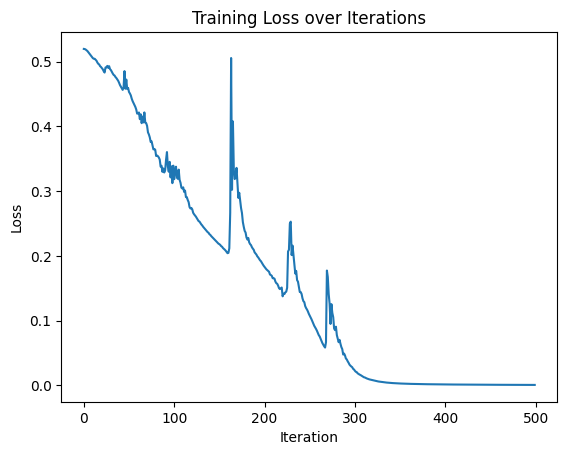

In [10]:
node_feature_dim = 2
edge_feature_dim = 0
condition_dim = hv_dim # 6400
# Initialize the GIN model
model = ConditionalGIN(
    input_dim=node_feature_dim,
    edge_dim=edge_feature_dim,
    condition_dim=condition_dim,
    cond_units=[1024, 512, 256],  # Simplified for testing
    conv_units=[128, 128, 64],  # Simplified for testing
    film_units=[256, 128],  # Simplified for testing
    link_units=[128, 64, 1]
)

batch_size_training = 8


loader = DataLoader(
    dataset=[sample_data for _ in range(batch_size_training)],
    batch_size=batch_size_training, shuffle=False)
batch = next(iter(loader))
data_cond = sample_data.cond
print(data_cond.shape)  # -> [num_nodes, 64]
batch_cond = batch.cond
print(batch_cond.shape)  # -> [num_nodes_in_batch, 64]

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Prepare to record losses
train_losses = []
for i in range(500):
    print(f"\n=== Iteration {i + 1} ===")

    # 1) Evaluation passos
    model.eval()
    with torch.no_grad():
        result = model(batch)
        edge_pred = result['edge_prediction']
    print("  [Eval] pred shape:", edge_pred.shape)
    print("  [Eval] first 20 preds:", edge_pred[:20].cpu().numpy().flatten())
    print("  [Eval] sum pred:", edge_pred.sum().item())
    print("  [Eval] first 20 targets:", sample_data.edge_y[:20].cpu().numpy().flatten())
    print("  [Eval] sum y:", sample_data.edge_y.sum().item() * 8)

    # 2) Training step
    model.train()
    batch = next(iter(loader))
    optimizer.zero_grad()
    loss = model.training_step(batch, 0)
    train_losses.append(loss.item())
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    print("  [Train] loss:", loss.item())

# After loop, plot losses
plt.figure()
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.show()

In [9]:
print([sample_data for _ in range(2)])

[Data(x=[18, 2], edge_index=[2, 168], edge_attr=[36], y=[1], edge_y=[168], sort_idx=[18], edge_index_old=[2, 36], cond=[18, 6400]), Data(x=[18, 2], edge_index=[2, 168], edge_attr=[36], y=[1], edge_y=[168], sort_idx=[18], edge_index_old=[2, 36], cond=[18, 6400])]
